In [ ]:
!pip install networkx mlxtend
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import classification_report, accuracy_score, silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import files
uploaded = files.upload()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Saving covid19.csv to covid19.csv


In [ ]:
# Load dataset
file_path = '/content/covid19.csv'
data = pd.read_csv(file_path)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 1. DATA PREPROCESSING

In [ ]:
# Handle missing values
numeric_cols = data.select_dtypes(include=np.number).columns
data[numeric_cols] = data[numeric_cols].replace([np.inf, -np.inf], np.nan)
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())
data.fillna(method='ffill', inplace=True)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-5-9b32f6d4b1dc>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [ ]:
# Encode categorical variables
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Normalize numerical features
from sklearn.preprocessing import StandardScaler # Import StandardScaler

data[data.select_dtypes(include=['float64', 'int64']).columns] = data[data.select_dtypes(include=['float64', 'int64']).columns].replace([np.inf, -np.inf], np.nan)
scaler = StandardScaler()
data[data.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(
    data.select_dtypes(include=['float64', 'int64'])
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2. FEATURE SELECTION

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


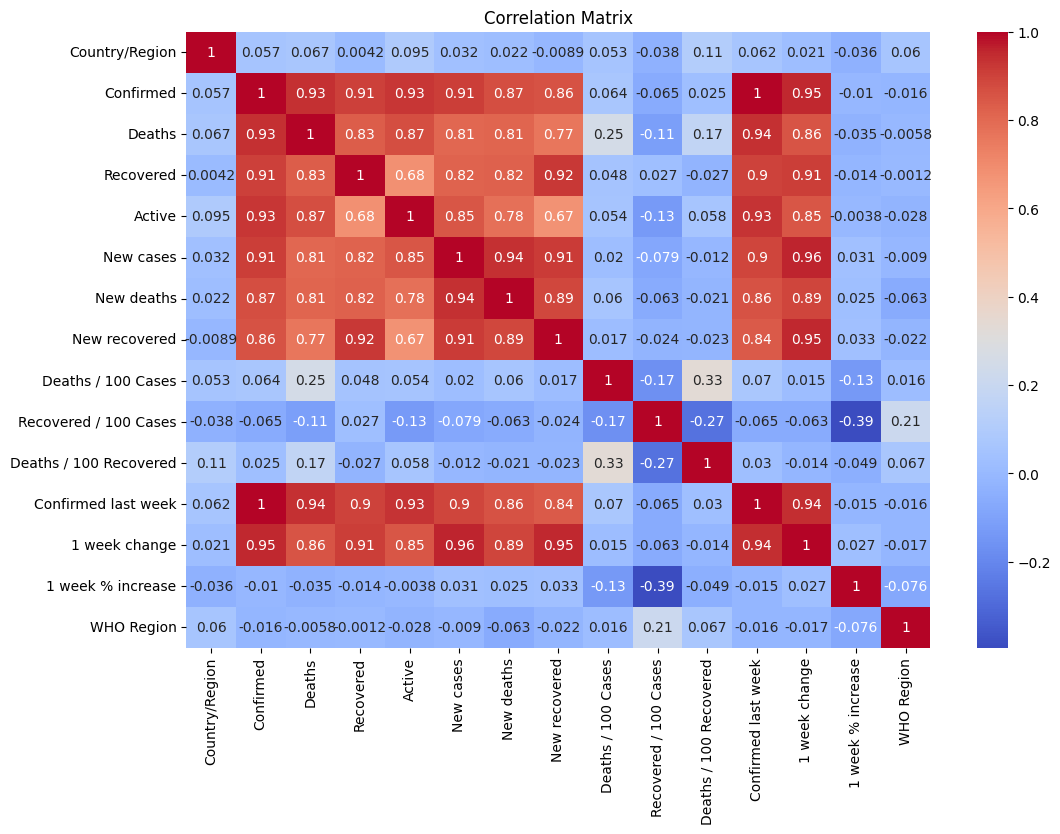

In [ ]:
# Correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
target_column_name = 'Confirmed' # Example: Replace 'Confirmed' with your actual target column name
selected_features = correlation_matrix.index[abs(correlation_matrix[target_column_name]) > 0.5]
data = data[selected_features]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Basic information about the dataset
data_info = data.info()
data_head = data.head()
data_describe = data.describe(include='all')
missing_values = data.isnull().sum()

data_info, data_head, data_describe, missing_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            187 non-null    float64
 1   Deaths               187 non-null    float64
 2   Recovered            187 non-null    float64
 3   Active               187 non-null    float64
 4   New cases            187 non-null    float64
 5   New deaths           187 non-null    float64
 6   New recovered        187 non-null    float64
 7   Confirmed last week  187 non-null    float64
 8   1 week change        187 non-null    float64
dtypes: float64(9)
memory usage: 13.3 KB


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(None,
    Confirmed    Deaths  Recovered    Active  New cases  New deaths  \
 0  -0.135676 -0.158475  -0.134087 -0.113774  -0.196126   -0.158352   
 1  -0.217768 -0.238477  -0.252461 -0.150459  -0.194195   -0.191764   
 2  -0.157361 -0.166013  -0.167623 -0.122342  -0.106576   -0.175058   
 3  -0.228160 -0.245019  -0.262699 -0.159573  -0.212983   -0.241883   
 4  -0.228048 -0.245801  -0.265657 -0.156682  -0.211578   -0.233530   
 
    New recovered  Confirmed last week  1 week change  
 0      -0.218755            -0.127921      -0.183926  
 1      -0.208006            -0.220861      -0.184517  
 2      -0.044145            -0.163001      -0.109080  
 3      -0.223054            -0.230604      -0.199001  
 4      -0.223054            -0.231004      -0.195242  ,
           Confirmed        Deaths     Recovered        Active     New cases  \
 count  1.870000e+02  1.870000e+02  1.870000e+02  1.870000e+02  1.870000e+02   
 mean  -9.499234e-18  5.937022e-18  2.374809e-17  4.749617e-18 -4.74

# 3. APRIORI

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Konversi data ke tipe bool
apriori_data = data > 0  # Menghasilkan DataFrame dengan nilai True/False
frequent_itemsets = apriori(apriori_data, min_support=0.1, use_colnames=True)

rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0, num_itemsets=len(apriori_data))
print("Apriori Rules:\n", rules.head())

Apriori Rules:
    antecedents            consequents  antecedent support  consequent support  \
0  (Confirmed)               (Deaths)            0.133690            0.139037   
1     (Deaths)            (Confirmed)            0.139037            0.133690   
2  (Confirmed)            (Recovered)            0.133690            0.149733   
3  (Recovered)            (Confirmed)            0.149733            0.133690   
4  (Confirmed)  (Confirmed last week)            0.133690            0.139037   

    support  confidence      lift  representativity  leverage  conviction  \
0  0.112299    0.840000  6.041538               1.0  0.093712    5.381016   
1  0.112299    0.807692  6.041538               1.0  0.093712    4.504813   
2  0.117647    0.880000  5.877143               1.0  0.097629    7.085561   
3  0.117647    0.785714  5.877143               1.0  0.097629    4.042781   
4  0.133690    1.000000  7.192308               1.0  0.115102         inf   

   zhangs_metric   jaccard  certai

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 4. NAIVE BAYES

In [ ]:
# Replace 'target_column' with the actual target column name from the Feature Selection section
X = data.drop(target_column_name, axis=1)
y = data[target_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
le = LabelEncoder()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Fit the encoder to your target variable and transform it
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test) # Transform y_test using the same encoder

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      56.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          11       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       0.0
          15       0.00      0.00      0.00       0.0
          16       0.00      0.00      0.00       0.0
          29       0.00      0.00      0.00       0.0
          34       0.00      0.00      0.00       0.0
          40       0.00      0.00      0.00       0.0
          42       0.00      0.00      0.00       0.0
          43       0.00      0.00      0.00       0.0
          44       0.00      0.00      0.00       0.0
          46       0.00      0.00      0.00  

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/pyth

# 5. DECISION TREE

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.02      0.04        56
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          23       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         0
          33       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          45       0.00      0.00      0.00         0
          56       0.00      0.00      0.00         0
          57       0.00      0.00      0.00         0
          58       0.00      0.00      0.00

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/pyth

# 6. K-MEANS CLUSTERING

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
data['kmeans_cluster'] = kmeans.fit_predict(X)
print("Silhouette Score for K-Means:", silhouette_score(X, data['kmeans_cluster']))

Silhouette Score for K-Means: 0.9453078591935022


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 7. DBSCAN

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
data['dbscan_cluster'] = dbscan.fit_predict(X)
print("Silhouette Score for DBSCAN:", silhouette_score(X, data['dbscan_cluster']))

Silhouette Score for DBSCAN: 0.8156188856016533


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 8. METRIC EVALUATION

In [ ]:
# Supervised Evaluation
print("Naive Bayes ARI:", adjusted_rand_score(y_test, y_pred_nb))
print("Decision Tree ARI:", adjusted_rand_score(y_test, y_pred_dt))

# Unsupervised Evaluation
print("K-Means Silhouette Score:", silhouette_score(X, data['kmeans_cluster']))
print("DBSCAN Silhouette Score:", silhouette_score(X, data['dbscan_cluster']))

Naive Bayes ARI: -0.020967063770147162
Decision Tree ARI: -0.000115738061618944
K-Means Silhouette Score: 0.9453078591935022
DBSCAN Silhouette Score: 0.8156188856016533


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
